In [1]:
import numpy as np
import torch
import torch.nn as nn
from timm.models import create_model
from vit_models import VisionTransformer
import lightning as L
from lightning import Trainer
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchmetrics.classification import Accuracy
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from lightning.pytorch.callbacks import ModelCheckpoint

In [2]:
def get_n_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def assert_tensors_equal(t1, t2):
    a1, a2, = t1.detach().numpy(), t2.detach().numpy()
    np.testing.assert_allclose(a1, a2)

In [3]:
model_name = "vit_base_patch16_224"
model_official = create_model(model_name, pretrained=True)
model_official.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [4]:
custom_config = {
        "img_size": 224,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4,
        "n_classes": 1000
}

In [5]:
model_custom = VisionTransformer(**custom_config)
model_custom.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=1000, bi

In [6]:
for (n_o, p_o), (n_c, p_c) in zip(model_official.named_parameters(), model_custom.named_parameters()):
    # print(p_o.numel(), p_c.numel())
    assert p_o.numel() == p_c.numel()
    print(f"{n_o} | {n_c}")
    p_c.data[:] = p_o.data
    assert_tensors_equal(p_c.data, p_o.data)

cls_token | cls_token
pos_embed | pos_embed
patch_embed.proj.weight | patch_embed.proj.weight
patch_embed.proj.bias | patch_embed.proj.bias
blocks.0.norm1.weight | blocks.0.norm1.weight
blocks.0.norm1.bias | blocks.0.norm1.bias
blocks.0.attn.qkv.weight | blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias | blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight | blocks.0.attn.proj.weight
blocks.0.attn.proj.bias | blocks.0.attn.proj.bias
blocks.0.norm2.weight | blocks.0.norm2.weight
blocks.0.norm2.bias | blocks.0.norm2.bias
blocks.0.mlp.fc1.weight | blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias | blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight | blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias | blocks.0.mlp.fc2.bias
blocks.1.norm1.weight | blocks.1.norm1.weight
blocks.1.norm1.bias | blocks.1.norm1.bias
blocks.1.attn.qkv.weight | blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias | blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight | blocks.1.attn.proj.weight
blocks.1.attn.proj.bias | blocks.1.attn.proj.b

In [6]:
for param in model_custom.parameters():
    param.requires_grad = False
    
model_custom.head = nn.Linear(custom_config['embed_dim'], 200)
# model_custom.pos_embed = nn.Parameter(torch.zeros(1, 1 + (custom_config['img_size'] // custom_config['patch_size']) ** 2, custom_config['embed_dim']))

In [7]:
model_custom.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=200, bia

In [8]:
# def get_mean_std(loader):
#     num_pixels = 0
#     mean = 0.0
#     std = 0.0
#     for images, _ in loader:
#         # print(images.shape)
#         batch_size, num_channels, height, width = images.shape
#         num_pixels += batch_size * height * width
#         mean += images.mean(axis=(0, 2, 3)).sum()
#         std += images.std(axis=(0, 2, 3)).sum()

#     mean /= num_pixels
#     std /= num_pixels
#     return mean, std


resize = transforms.Resize(size=(224, 224), antialias=True)


# t_data = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/train', transform=transforms.ToTensor())
# v_data = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/val', transform=transforms.ToTensor())

# t_mean, t_std = get_mean_std(DataLoader(t_data, batch_size=500, shuffle=True))
# v_mean, v_std = get_mean_std(DataLoader(v_data, batch_size=50))

train_compose = transforms.Compose([
resize,
transforms.ToTensor(),
# transforms.Normalize(mean=t_mean, std=t_std)
])

val_compose = transforms.Compose([
resize,
transforms.ToTensor(),
# transforms.Normalize(mean=v_mean, std=v_std)
])

In [9]:
train_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/train', transform=train_compose)
val_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/val', transform=val_compose)

In [10]:
train_labels = {}
for mapping in open('/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/words.txt','r').readlines():
    maps = mapping.replace('\n','').split('\t')
    train_labels[maps[0]] = maps[1]

def train_map_labels(dataset):
    class_labels = {}
    for ind in range(0, 100000, 500):
        class_name = dataset.imgs[ind][0].split('/')[-1].split('_')[0]
        class_label = dataset[ind][1]
        class_labels[class_label] = class_name
    return class_labels

# for ind, (k,v) in enumerate(train_labels.items()):
#     print(k,v)
#     if ind > 10:
#         break

train_class_labels = train_map_labels(train_dataset)

for ind, (k, v) in enumerate(train_class_labels.items()):
    print(k, v, train_labels[v])
    if ind == 20:
        break

0 n01443537 goldfish, Carassius auratus
1 n01629819 European fire salamander, Salamandra salamandra
2 n01641577 bullfrog, Rana catesbeiana
3 n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
4 n01698640 American alligator, Alligator mississipiensis
5 n01742172 boa constrictor, Constrictor constrictor
6 n01768244 trilobite
7 n01770393 scorpion
8 n01774384 black widow, Latrodectus mactans
9 n01774750 tarantula
10 n01784675 centipede
11 n01855672 goose
12 n01882714 koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
13 n01910747 jellyfish
14 n01917289 brain coral
15 n01944390 snail
16 n01945685 slug
17 n01950731 sea slug, nudibranch
18 n01983481 American lobster, Northern lobster, Maine lobster, Homarus americanus
19 n01984695 spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
20 n02002724 black stork, Ciconia nigra


In [11]:
for i in range(0, 10000, 50):
    class_label = val_dataset.imgs[i][0].split('/')[-3]
    print(val_dataset[i][1], class_label, train_labels[class_label])
    if i == 1000:
        break

0 n01443537 goldfish, Carassius auratus
1 n01629819 European fire salamander, Salamandra salamandra
2 n01641577 bullfrog, Rana catesbeiana
3 n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
4 n01698640 American alligator, Alligator mississipiensis
5 n01742172 boa constrictor, Constrictor constrictor
6 n01768244 trilobite
7 n01770393 scorpion
8 n01774384 black widow, Latrodectus mactans
9 n01774750 tarantula
10 n01784675 centipede
11 n01855672 goose
12 n01882714 koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
13 n01910747 jellyfish
14 n01917289 brain coral
15 n01944390 snail
16 n01945685 slug
17 n01950731 sea slug, nudibranch
18 n01983481 American lobster, Northern lobster, Maine lobster, Homarus americanus
19 n01984695 spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
20 n02002724 black stork, Ciconia nigra


In [12]:
batch_size = 300
lr = 1e-7
class VisionTransformerWrapper(L.LightningModule):
    
    def __init__(self, model):
        super(VisionTransformerWrapper, self).__init__()
        self.model = model
        self.accuracy = Accuracy(task="multiclass", num_classes=200)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, log_name="train", on_epoch=False, on_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, log_name="val", on_epoch=True, on_step=False)
        
    def _common_step(self, batch, batch_idx, log_name="", on_epoch=True,  on_step=True):
        images, labels = batch
        outputs = self(images)

        loss = F.cross_entropy(outputs, labels)
        self.log(f"{log_name}_loss", loss, on_step=on_step, on_epoch=on_epoch, prog_bar=True, logger=True)
        
        self.accuracy(outputs, labels)
        
        self.log(f"{log_name}_acc", self.accuracy, on_step=on_step, on_epoch=on_epoch, prog_bar=True, logger=True)
        
        return loss
        
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), weight_decay=1e-3, lr=lr)
        
    def train_dataloader(self):
        train_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/train', transform=train_compose)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=11, persistent_workers=True)
        return train_loader

    def val_dataloader(self):
        val_dataset = torchvision.datasets.ImageFolder(root='/Users/ykamoji/Documents/ImageDatabase/imageNet/tiny-imagenet-200/val', transform=val_compose)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=11, persistent_workers=True)
        return val_loader

In [13]:
checkpoint_callback = ModelCheckpoint(
    dirpath=os.getcwd()+"/fine_tune_models/",
    save_top_k=2,
    verbose=True,
    monitor='val_acc',
    every_n_train_steps=10,
    mode='max',
    filename='imagnet-tiny-{epoch:02d}-{val_acc:.2f}'
)

In [18]:
trainer = Trainer(max_epochs=1,
                  log_every_n_steps=11, 
                  val_check_interval=30,
                  # limit_val_batches=20,
                  callbacks=[checkpoint_callback])

model = VisionTransformerWrapper.load_from_checkpoint(os.getcwd()+"/fine_tune_models/"+'best-model.ckpt', model=model_custom)
# model = VisionTransformerWrapper(model_custom)
model.eval()
# model_custom.train()
# trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


VisionTransformerWrapper(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((768,), eps=1e-0

In [72]:
# checkpoint = torch.load(os.getcwd()+"/fine_tune_models/"+'imagnet-tiny-epoch=00-train_loss=0.30.ckpt')
# checkpoint.keys()

196 val coral reef


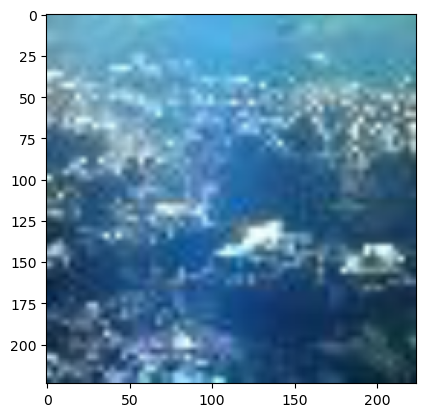

In [30]:
index = 9800
plt.imshow(torch.permute(val_dataset[index][0], (1,2,0)).numpy())
label_class = val_dataset.imgs[index][0].split('/')[-1].split('_')[0]
label_num = val_dataset[index][1]
print(label_num, label_class, train_labels[train_class_labels[label_num]])

In [31]:
model.cpu().eval()
logits = model(resize(val_dataset[index][0].unsqueeze(0).to(torch.float32)))
probs = torch.nn.functional.softmax(logits, dim=-1)
top_probs, top_ixs = probs[0].topk(5)
# print(f"\n{image}")
for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
    ix = ix_.item()
    prob = prob_.item()
    cls = train_labels[train_class_labels[ix]]
    print(f"{i}: {cls:<45} --- {prob:.4f}")
    
probs = torch.argmax(logits, dim=-1)
print(f"{train_labels[train_class_labels[probs.item()]]}")

0: coral reef                                    --- 0.9025
1: seashore, coast, seacoast, sea-coast          --- 0.0256
2: lakeside, lakeshore                           --- 0.0223
3: alp                                           --- 0.0098
4: snorkel                                       --- 0.0085
coral reef
